In [1]:
#import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.cluster import KMeans
from scipy.stats import zscore


In [2]:
#load dataset
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

#Create copy of train and test
traincopy = train.copy()
testcopy = test.copy()

In [3]:
def falg_func(x):
    #flag function
    if x==1:
        return 1
    elif x==2:
        return 2
    elif x==3:
        return 3
    elif x==4:
        return 4
    else:
        return 0
    
def season_map(x):
    if (x == 12 or x==  1 or  x ==2):
        return 1
    if (x == 3 or x== 4  or  x ==5):
        return 2
    if (x == 6 or x==  7 or  x ==8):
        return 3
    if (x == 9 or x==  10 or  x ==11):
        return 4

### Preprocessing

In [4]:
#calculate GHI 
ghi_estmates = train['Clearsky DNI']*np.cos(train['Solar Zenith Angle']*np.pi/180)+train['Clearsky DHI']

In [5]:
#concat train and test data
train['Phase'] = 'train'
test['Phase'] = 'test'
alldf = pd.concat([train,test],axis=0)

In [6]:
def preprocessing(train):
    #TIME features (year montd day and time)
    train['time'] = pd.to_datetime(train[['Year','Month','Day','Hour','Minute']])

    #diff between temp and due point  ~ 
    #he smaller the difference between the temp and the dew_point, the higher the RH
    train['dewpoint-temp'] = train['Temperature']-train['Dew Point']

    #RelativeHumidity and temp
    train['RHxTemp'] = train['Relative Humidity']*train['Temperature']

    #Relative Humidity Index(RHI)
    train['RHI'] = 0.8*train['Temperature']+train['Relative Humidity']/100*(train['Temperature']-14.4)+46
    
    #flag function
    train['Fill Flag'] = train['Fill Flag'].apply(falg_func)

    #pressure class
    train['Pressure_class'] =pd.cut(train['Pressure'],bins=[0,999,1008,1013,1040],labels=[0,1,2,3])

    #wind directions class 
    train['WindDirection_Class'] = pd.cut(train['Wind Direction'],bins=8,labels=[1,2,3,4,5,6,7,8])

    #sine transform of wind direction
    train['WindDirection_Sine'] = (np.sin(train['Wind Direction']*(np.pi/180)))

    #outliers - Cloudtype 10 replace with 0
    train['Cloud Type'][train['Cloud Type']==10] = 0
    return train

In [7]:
#preprocessing for train and test data
alldf = preprocessing(alldf)

#split the data into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

In [8]:
def iqr_range(value):
    q1 = value.quantile(0.25)
    q3 = value.quantile(0.75)
    iqr = q3 - q1
    return q1-1.5*iqr,q3+1.5*iqr

<AxesSubplot:xlabel='time', ylabel='Clearsky DHI'>

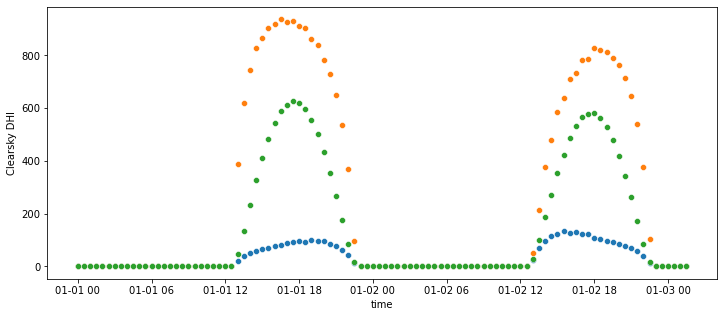

In [9]:
#visualize each target features
plt.figure(figsize=(12,5))
subdf = train[:100]
sns.scatterplot(data=subdf,x='time',y='Clearsky DHI')
sns.scatterplot(data=subdf,x='time',y='Clearsky DNI')
sns.scatterplot(data=subdf,x='time',y='Clearsky GHI')

* The day and night time periods
* There might be some correlation between target varibles (we found the equation for GHI)

* a region with a temperature of 18° and relative humidity of 40% is considered too dry whereas the region with 23° temperature and 70% relative humidity comes in the range of too moist regions. The regions between these two extremes are acceptable such as regions with 24° temperature and 50% humidity. In this way, their relationship affects the region.

* Relation between pressure and clouds

## Feature Engineering

In [10]:
def feature_engineering(train):
    #combine hour and minutes
    train['ThirtyMinutesCycle'] = train['Hour']*60 + train['Minute']
    
    #Seasons
    train['Season'] =  train['Month'].apply(lambda x:season_map(x))
    
    #Mean Humidity ZeningAngle WindDire by Hour and Minute
    train[['RelHumid_HourMinute','ZenithAng_HourMinute','WindDir_HourMinute']] =\
            train.groupby(['Hour','Minute'])['Relative Humidity', 'Solar Zenith Angle','Wind Direction'].transform('mean')

    #Mean Humidity ZeningAngle WindDire Temperature by Year and Month
    train[['RelHumid_YearMonth','WindDir_YearMonth','Temp_YearMonth']] =\
                train.groupby(['Year','Month'])['Relative Humidity','Wind Direction','Temperature'].transform('mean')

    #Mean Humidity ZeningAngle WindDire Temperature by Year and Month
    train[['RelHumid_SeasonYear','WindDir_SeasonYear','Temp_SeasonYear']] =\
                train.groupby(['Season','Year'])['Relative Humidity','Wind Direction','Temperature'].transform('mean')

    # Delta (diff)
    #change in Humidity
    train['delta_RelativeHumidity'] = train['Relative Humidity'].diff()
    #change in Temperature
    train['delta_Temperature'] = train['Temperature'].diff()
    #change in Dew Point
    train['delta_DewPoint'] = train['Dew Point'].diff()
    #change in Precipitable Water
    train['delta_PrecipWater'] = train['Precipitable Water'].diff()
    #change in Wind Speed
    train['delta_WindSpeed'] = train['Wind Speed'].diff()

    #Cloud Types and Pressure Class
    train[['CloudPressure_RelaHumidity', 'CloudPressure_PrecWater','CloudPressure_DewPoint','CloudPressure_Temp']] =\
    train.groupby(['Pressure_class','Cloud Type'])['Relative Humidity', 'Precipitable Water','Dew Point','Temperature'].transform('mean')
    
    #Monthly aggregation zscore
    train['Temp_zscore_monthly'] = train.groupby(['Month'])['Temperature'].transform(lambda x : zscore(x,ddof=1))
    train['Pressure_zscore_monthly'] = train.groupby(['Month'])['Pressure'].transform(lambda x : zscore(x,ddof=1))
    train['RelHum_zscore_monthly'] = train.groupby(['Month'])['Relative Humidity'].transform(lambda x : zscore(x,ddof=1))
    train['PrecWater_zscore_monthly'] = train.groupby(['Month'])['Precipitable Water'].transform(lambda x : zscore(x,ddof=1))
    train['WindSpeed_zscore_monthly'] = train.groupby(['Month'])['Wind Speed'].transform(lambda x : zscore(x,ddof=1))
    
    #Yearly aggregation zscore
    train['Temp_zscore_monthly'] = train.groupby(['Year'])['Temperature'].transform(lambda x : zscore(x,ddof=1))
    train['Pressure_zscore_monthly'] = train.groupby(['Year'])['Pressure'].transform(lambda x : zscore(x,ddof=1))
    train['RelHum_zscore_monthly'] = train.groupby(['Year'])['Relative Humidity'].transform(lambda x : zscore(x,ddof=1))
    train['PrecWater_zscore_monthly'] = train.groupby(['Year'])['Precipitable Water'].transform(lambda x : zscore(x,ddof=1))
    train['WindSpeed_zscore_monthly'] = train.groupby(['Year'])['Wind Speed'].transform(lambda x : zscore(x,ddof=1))
    
    
    #simple transformation
    train['TempXRelHumidity'] = train['Temperature']*train['Relative Humidity']
    train['TempXSolarAngle'] = train['Temperature']*train['Solar Zenith Angle']
    train['TempXRelHumidity'] = train['Temperature']*train['Relative Humidity']
    train['TempXPrecWater'] = train['Temperature']*train['Precipitable Water'] 
    train['TempXWindSpeed'] = train['Temperature']*train['Wind Speed'] 
    
    # group by feats_gr and calc mean,std of feats_agg
    feats_gr  = ['Year','Month']
    feats_agg = ['Dew Point','Temperature', 'Pressure', 'Relative Humidity','Precipitable Water', 'Wind Direction']
    df = train.groupby(feats_gr)[feats_agg].agg([np.mean, np.std])
    cols = df.columns
    df.columns = ['_YrMnth_'.join(c) for c in cols]
    df.reset_index(inplace = True)
    #join df with train
    train = train.merge(df, on = feats_gr, how = 'left')
    
    # group by feats_gr and calc mean,std of feats_agg
    feats_gr  = ['Month','ThirtyMinutesCycle']
    feats_agg = ['Dew Point','Temperature', 'Pressure', 'Relative Humidity','Precipitable Water', 'Wind Direction']
    df = train.groupby(feats_gr)[feats_agg].agg([np.mean, np.std])
    cols = df.columns
    df.columns = ['_MnthMints_'.join(c) for c in cols]
    df.reset_index(inplace = True)
    #join df with train
    train = train.merge(df, on = feats_gr, how = 'left')
    
    # group by feats_gr and calc mean,std of feats_agg
    feats_gr  = ['Season','ThirtyMinutesCycle']
    feats_agg = ['Dew Point','Temperature', 'Pressure', 'Relative Humidity','Precipitable Water', 'Wind Direction']
    df = train.groupby(feats_gr)[feats_agg].agg([np.mean, np.std])
    cols = df.columns
    df.columns = ['_SeasMinuts_'.join(c) for c in cols]
    df.reset_index(inplace = True)
    #join df with train
    train = train.merge(df, on = feats_gr, how = 'left')

    # group by feats_gr and calc mean,std of feats_agg
    feats_gr  = ['Season','Cloud Type']
    feats_agg = ['Dew Point','Temperature', 'Pressure', 'Relative Humidity','Precipitable Water', 'Wind Direction']
    df = train.groupby(feats_gr)[feats_agg].agg([np.mean])
    cols = df.columns
    df.columns = ['_SeasCloud_'.join(c) for c in cols]
    df.reset_index(inplace = True)
    #join df with train
    train = train.merge(df, on = feats_gr, how = 'left')
    
    # group by feats_gr and calc mean,std of feats_agg
    feats_gr  = ['Fill Flag','ThirtyMinutesCycle']
    feats_agg = ['Dew Point','Temperature','Relative Humidity','Precipitable Water']
    df = train.groupby(feats_gr)[feats_agg].agg([np.mean])
    cols = df.columns
    df.columns = ['_FlagMinute_'.join(c) for c in cols]
    df.reset_index(inplace = True)
    #join df with train
    train = train.merge(df, on = feats_gr, how = 'left')
    
    # group by feats_gr and calc mean,std of feats_agg
    feats_gr  = ['Fill Flag','Cloud Type']
    feats_agg = ['Dew Point','Temperature','Relative Humidity','Precipitable Water']
    df = train.groupby(feats_gr)[feats_agg].agg([np.mean])
    cols = df.columns
    df.columns = ['_FlagCloud_'.join(c) for c in cols]
    df.reset_index(inplace = True)
    #join df with train
    train = train.merge(df, on = feats_gr, how = 'left')
    
    
    return train

In [11]:
#feature engineering 
alldf = feature_engineering(alldf)
#split the data into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

#drop nan obs values in moving averages (drop entire row)
train = train.dropna(axis=0).reset_index(drop=True)
alldf = pd.concat([train,test],axis=0)

In [12]:
#pca features
num_feats = ['Temperature','Pressure', 'Relative Humidity', 'Solar Zenith Angle','Precipitable Water', 'Wind Direction', 'Wind Speed', 'Fill Flag','WindDir_YearMonth', 
'ZenithAng_HourMinute', 'WindDir_HourMinute', 'RelHumid_YearMonth','Temp_YearMonth', 'RelHumid_SeasonYear',
'WindDir_SeasonYear', 'Temp_SeasonYear', 'delta_RelativeHumidity','delta_Temperature', 'delta_DewPoint', 'delta_PrecipWater','delta_WindSpeed',
'CloudPressure_RelaHumidity','CloudPressure_PrecWater', 'CloudPressure_DewPoint','CloudPressure_Temp']
#pca components as new features
pca = decomposition.IncrementalPCA(n_components=10)
emb = pca.fit_transform(alldf[num_feats].values)
for i in range(emb.shape[1]):
    alldf[f'pca_{i+1}'] = emb[:, i]
                        
# cluaset -- Fit the KMeans model to create cluster labels
kmeans = KMeans(n_clusters=2, n_init=50, random_state=0)
alldf['cluster']=  kmeans.fit_predict(alldf[num_feats].values)

In [13]:
# # Create correlation matrix
# targets = ['Clearsky DNI','Clearsky DHI','Clearsky GHI']
# corr_matrix = alldf.drop(targets,axis=1).corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# #drop high correlated feats
# alldf.drop(columns=to_drop,inplace=True)

# Modelling

In [14]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler

In [15]:
def metrics_print(actual, predicted, data_set):
    print(f'{data_set}')
    print('RMSE', np.sqrt(mean_squared_error(actual, predicted)))
    print('MAE', mean_absolute_error(actual, predicted))
    print('r2_score', r2_score(actual, predicted))

In [16]:
#split numerical and categorical data
drop_feats = ['time','Day','Minute','Hour','Year','Month']  
cat_feats = [ 'Cloud Type','Fill Flag','Pressure_class','WindDirection_Class']

num_feats = [feat for feat in alldf.columns if (feat not in cat_feats and feat not in  drop_feats)]
num_feats.remove('Phase')

#get dummies for categorical features and drop drop_feats
finaldf =  pd.get_dummies(alldf,columns=cat_feats)
finaldf = finaldf.drop(columns=drop_feats)

#split the data into train and test
traindata = finaldf[finaldf['Phase']=='train']
testdata = finaldf[finaldf['Phase']=='test']
traindata.drop(columns='Phase',inplace=True)
testdata.drop(columns='Phase',inplace=True)

### DHI

In [17]:
# training 3 models
model1_DHI = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=8,reg_lambda=7)

model2_DHI = CatBoostRegressor(n_estimators = 1000,learning_rate = 0.0467250359539884,
                               depth = 8,l2_leaf_reg = 3,verbose=False)

model3_DHI = LGBMRegressor(num_leaves=40,n_estimators=300,reg_lambda =4,verbose=0)

In [18]:
#train using best params
target = 'Clearsky DHI'
targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
df_DHI = traindata.drop(columns = ['Clearsky DNI','Clearsky GHI'])
X = df_DHI.drop(columns=target,axis=1)
y = df_DHI[target]

# Split the train data into train and validation
x_train_H,x_valid_H,y_train_H,y_valid_H = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=1)

In [19]:
# #train each models
model1_DHI.fit(x_train_H,y_train_H)
model2_DHI.fit(x_train_H,y_train_H)
model3_DHI.fit(x_train_H,y_train_H)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075634 seconds.
You can set `force_col_wise=true` to remove the overhead.


LGBMRegressor(n_estimators=300, num_leaves=40, reg_lambda=4, verbose=0)

In [37]:
wH = [0,1,0]
train_pred_H = (wH[0]*model1_DHI.predict(x_train_H) +\
              wH[1]*model2_DHI.predict(x_train_H) +\
              wH[2]*model3_DHI.predict(x_train_H))

valid_pred_H = (wH[0]*model1_DHI.predict(x_valid_H) +\
              wH[1]*model2_DHI.predict(x_valid_H) +\
              wH[2]*model3_DHI.predict(x_valid_H))

#validation score
metrics_print(train_pred_H, y_train_H.values, 'train')
metrics_print(valid_pred_H, y_valid_H.values, 'valid')

train
RMSE 9.376477953878911
MAE 4.920271588056806
r2_score 0.977819857405294
valid
RMSE 10.674068022043016
MAE 5.456357971835945
r2_score 0.9709262367564707


In [21]:
# train
# RMSE 10.238985387632962
# MAE 5.248473332741532
# r2_score 0.9734303959948302
# valid
# RMSE 11.34634905044951
# MAE 5.670046843047136
# r2_score 0.9669016281200691


# train
# RMSE 9.782911501452684
# MAE 5.037678858415036
# r2_score 0.9758003784953656
# valid
# RMSE 10.941659701563948
# MAE 5.484292423679849
# r2_score 0.9692860577984447


In [38]:
# Predict for test data
tdf = testdata.drop(columns = targets)
test_pred_DHI = (wH[0]*model1_DHI.predict(tdf) +\
             wH[1]*model2_DHI.predict(tdf) +\
             wH[2]*model3_DHI.predict(tdf))

test[target] = test_pred_DHI

### DNI

In [22]:
# training 2 models
# training 3 models
model1_DNI = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=7,reg_lambda=7)

model2_DNI = CatBoostRegressor(n_estimators = 1000,learning_rate = 0.0467250359539884,
                               depth = 8,l2_leaf_reg = 3,verbose=False)

model3_DNI = LGBMRegressor(num_leaves=40,n_estimators=300,reg_lambda =4,verbose=0)

In [23]:
#train using best params
target = 'Clearsky DNI'
targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
df_DHI = traindata.drop(columns = ['Clearsky DHI','Clearsky GHI'])
X = df_DHI.drop(columns=target,axis=1)
y = df_DHI[target]

# Split the train data into train and validation
x_train_N,x_valid_N,y_train_N,y_valid_N = train_test_split(X,y,test_size=0.2,random_state=1)

In [24]:
# #train each models
model1_DNI.fit(x_train_N,y_train_N)
model2_DNI.fit(x_train_N,y_train_N)
model3_DNI.fit(x_train_N,y_train_N)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083080 seconds.
You can set `force_col_wise=true` to remove the overhead.


LGBMRegressor(n_estimators=300, num_leaves=40, reg_lambda=4, verbose=0)

In [25]:
wN = [0,0,0.3]
train_pred_N = (wN[0]*model1_DNI.predict(x_train_N) +\
              wN[1]*model2_DNI.predict(x_train_N) +\
              wN[2]*model3_DNI.predict(x_train_N))

valid_pred_N = (wN[0]*model1_DNI.predict(x_valid_N) +\
              wN[1]*model2_DNI.predict(x_valid_N) +\
              wN[2]*model3_DNI.predict(x_valid_N))

#validation score
metrics_print(train_pred_N, y_train_N.values, 'train')
metrics_print(valid_pred_N, y_valid_N.values, 'valid')

train
RMSE 25.091917188451333
MAE 13.756940593527775
r2_score 0.995364304157757
valid
RMSE 27.940174674553976
MAE 15.095056581472749
r2_score 0.9942597979156693


In [27]:
# train
# RMSE 27.52243563520499
# MAE 15.28212393049243
# r2_score 0.9944184585018621
# valid
# RMSE 29.53151544801847
# MAE 16.229806159203413
# r2_score 0.9935866451200136


# train
# RMSE 26.7498982541645
# MAE 14.953997234840566
# r2_score 0.9947303084266268
# valid
# RMSE 28.89508266153263
# MAE 15.941440880214213
# r2_score 0.9938614027793098

In [26]:
# Predict for test data
tdf = testdata.drop(columns = targets)
test_pred_DNI = (wN[0]*model1_DNI.predict(tdf) +\
             wN[1]*model2_DNI.predict(tdf) +\
             wN[2]*model3_DNI.predict(tdf))

test[target] = test_pred_DNI

### Estimate GHI

In [27]:
predictiondf = test.copy()
predictiondf['Clearsky GHI'] = predictiondf['Clearsky DNI']*np.cos(predictiondf['Solar Zenith Angle']*np.pi/180)+predictiondf['Clearsky DHI']

In [33]:
night = [60,   90,  120,  150,  180,  210,  240,  270,  300,
        330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,]

In [34]:
predictiondf.loc[predictiondf['ThirtyMinutesCycle'].isin(night),['Clearsky DHI','Clearsky DNI','Clearsky GHI']] = 0

In [35]:
#save output
predictiondf[['Clearsky DHI','Clearsky DNI','Clearsky GHI']].to_csv('finalday2.csv',index=False)